# An example breakout strategy on ETH-USDC pairs

This is an example algorithmic trading strategy backtest for ETH-USDC pair on Uniswap v3 on Arbitrum blockchain.

- Trading DEX spot market, long only
- Bollinger bands technical indicator based breakout strategy
- Run the trailing stop loss strategy on 
- Use hourly candles instead
- Open positions with 80% of trading capital 
- Use 15 minute candles for stop loss trigger
- Demostrates how to generate 40% yearly returns and $7M yearly volume with $10,000 initial capital
- Maximum drawdown is a bit risky 15%
- Backtested 2022-06 - 2023-06


## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for technical indicators

In [20]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import TradeRouting, ReserveCurrency

# How our trades are routed.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1

# Which trading pair we are backtesting on
TRADING_PAIR = (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005)

# How much % of the cash to put on a single trade
POSITION_SIZE = 0.80

# Start with this amount of USD
INITIAL_DEPOSIT = 10_000

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.m15

#
# Strategy thinking specific parameter
#

# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 90

# Moving average 
# 
# How many candles to smooth out for Bollinger band's middle line
EMA_CANDLE_COUNT = 20  

# How many candles we use to calculate the Relative Strength Indicator
RSI_LENGTH = 14

# RSI must be above this value to open a new position
RSI_THRESHOLD = 20

# Backtest range
START_AT = datetime.datetime(2022, 6, 1)
END_AT = datetime.datetime(2023, 6, 1)

# Stop loss relative to the mid price during the time when the position is opened
#
# If the price drops below this level, trigger a stop loss
STOP_LOSS_PCT = 0.98

# What is the trailing stop loss level
TRAILING_STOP_LOSS_PCT = 0.9975

# Activate trailing stop loss when this level is reached
TRAILING_STOP_LOSS_ACTIVATION_LEVEL=1.03


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- See README for explanations on technical indicators used


In [21]:
from typing import List, Dict

from pandas_ta import bbands
from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi

from tradingstrategy.universe import Universe

from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
        timestamp: pd.Timestamp,
        universe: Universe,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what trades to do next, if any, at current timestamp.

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        TRADING_STRATEGY_CYCLE division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """

    # We have only a single trading pair for this strategy.
    pair = universe.pairs.get_single()

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/overlap/help/pandas_ta.overlap.ema.html#ema
    moving_average = ema(close_prices, length=EMA_CANDLE_COUNT)

    # Calculate RSI for candle close
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    current_rsi = rsi(close_prices, length=RSI_LENGTH)[-1]

    trades = []

    if moving_average is None:
        # Cannot calculate EMA, because
        # not enough samples in backtesting buffer yet.
        return trades

    price_latest = close_prices.iloc[-1]

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, universe, state, pricing_model)

    # Calculate Bollinger Bands with a 20-day SMA and 2 standard deviations using pandas_ta
    # See documentation here https://tradingstrategy.ai/docs/programming/api/technical-analysis/volatility/help/pandas_ta.volatility.bbands.html#bbands
    bollinger_bands = bbands(close_prices, length=20, std=1)
    bb_upper = bollinger_bands["BBU_20_1.0"]
    bb_lower = bollinger_bands["BBL_20_1.0"]

    if not position_manager.is_any_open():
        # No open positions, decide if BUY in this cycle.
        # We buy if the price on the daily chart closes above the upper Bollinger Band.
        if price_latest > bb_upper.iloc[-1] and current_rsi >= RSI_THRESHOLD:
            buy_amount = cash * POSITION_SIZE
            new_trades = position_manager.open_1x_long(pair, buy_amount, stop_loss_pct=STOP_LOSS_PCT)
            trades.extend(new_trades)

    else:
        # We have an open position, decide if SELL in this cycle.
        # We close the position when the price closes below the 20-day moving average.        
        if price_latest < moving_average.iloc[-1]:
            new_trades = position_manager.close_all()
            trades.extend(new_trades)

        # Check if we have reached out level where we activate trailing stop loss
        position = position_manager.get_current_position()
        if price_latest >= position.get_opening_price() * TRAILING_STOP_LOSS_ACTIVATION_LEVEL:
            position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_PCT
            position.stop_loss = float(price_latest * TRAILING_STOP_LOSS_PCT)
        
    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "BB upper", PlotKind.technical_indicator_on_price, bb_upper.iloc[-1], colour="darkblue")
    visualisation.plot_indicator(timestamp, "BB lower", PlotKind.technical_indicator_on_price, bb_lower.iloc[-1], colour="darkblue")
    visualisation.plot_indicator(timestamp, "EMA", PlotKind.technical_indicator_on_price, moving_average.iloc[-1], colour="darkgreen")
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, current_rsi)

    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, single exchange and a single trading pair.

Trading Strategy framework supports complex strategies, spanning thousands of pairs and lending pools,
but we are not interested in this example.

In [22]:
import datetime
from tradingstrategy.client import Client
from tradeexecutor.strategy.trading_strategy_universe import load_pair_data_for_single_exchange, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions


def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    
    # Fetch backtesting datasets from the server 
    dataset = load_pair_data_for_single_exchange(
        client,
        time_bucket=CANDLE_TIME_BUCKET,
        pair_tickers=[TRADING_PAIR],
        execution_context=execution_context,        
        universe_options=universe_options,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Convert loaded data to a trading pair universe
    universe = TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )

    return universe

## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [23]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


## Load data

This will pull JSONL data feed for the trading pair from Trading Strategy oracle node.

In [24]:
from tradeexecutor.strategy.execution_context import ExecutionMode
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    ExecutionContext(mode=ExecutionMode.data_preload),
    UniverseOptions()
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for 42161-uniswap-v3:   0%|          | 0/58229356 [00:00<?, ?it/s]

Loading granular price data for stop loss/take profit for None:   0%|          | 0/58228459 [00:00<?, ?it/s]

We loaded 16,144 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.


In [25]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="Bollinger bands example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/31536000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 734 trades


## Analysing the backtest results

Examine `state` that contains all actions the trade executor took.


In [26]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 367
Trades made: 734


### Equity curve and drawdown

Visualise equity curve and related performnace over time.

- Returns

- Drawdown

- Daily returns



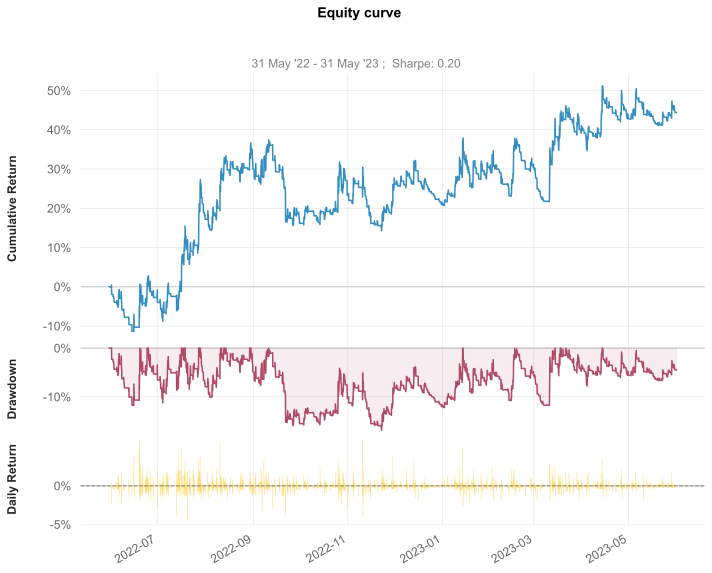

In [27]:
from tradeexecutor.backtest.notebook import setup_charting_and_output
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

# Set Jupyter Notebook output mode parameters
setup_charting_and_output()

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Returns monthly breakdown

- Monthly returns
- Best day/week/month/year


/Users/moo/Library/Caches/pypoetry/virtualenvs/tradingview-defi-strategy-XB2Vkmi1-py3.10/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


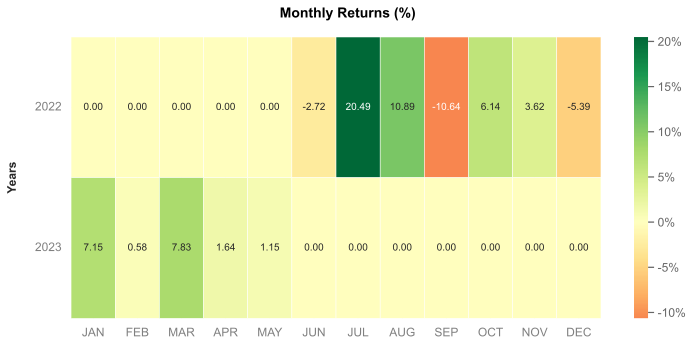

In [28]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

### Returns distribution

Show the difference between good and bad trading periods.

- Daily/montly/yearly

- Best/worst/avg.

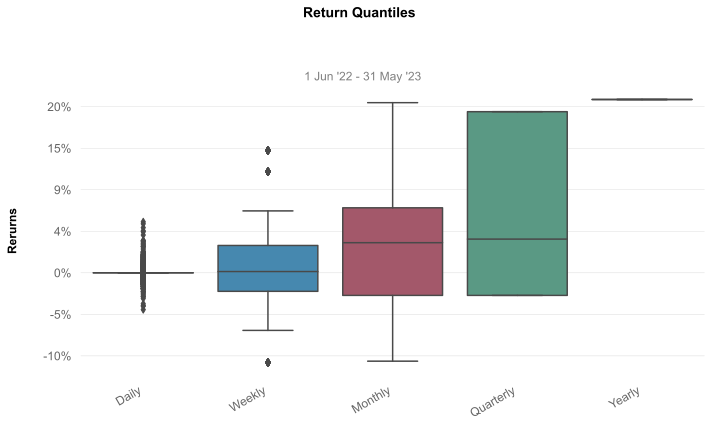

In [29]:
from tradeexecutor.visual.equity_curve import visualise_returns_distribution

visualise_returns_distribution(returns)

### Price action and technical indicators

- Plot the prica action for the trading pair we backtested.
- Overlay trades on the top of technical indicators

In [30]:

from tradeexecutor.visual.single_pair import visualise_single_pair, visualise_single_pair_positions_with_duration_and_slippage
from tradingstrategy.charting.candle_chart import VolumeBarMode

# figure = visualise_single_pair(
#     state,
#     universe.universe.candles,
#     start_at=START_AT,
#     end_at=END_AT,
#     volume_bar_mode=VolumeBarMode.separate,
#     volume_axis_name="Volume (USD)",
#     height = 1000,
# )

# figure.show()

### Position visualisation

- Visualise individual positions over the price timeline

- Hover your mouse on the position marker circle to get its underlying details

- Positions closed for profit are marked green while losing ones are red

In [31]:
candles = universe.universe.candles.get_candles_by_pair(universe.get_single_pair().internal_id)

#figure2 = visualise_single_pair_positions_with_duration_and_slippage(
#    state,
#    candles,
#    start_at=START_AT,
#    end_at=END_AT,
#)

#figure2.show()
print("Not shown as the chart is too cluttered and slow")

Not shown as the chart is too cluttered and slow


### Benchmarks

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold ETH


In [32]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    "Bollinger bands example strategy",
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

### Analyse trade statistics

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [33]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Trade summary

Overview of strategy performance



In [34]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

,0
Trading period length,363 days
Return %,44.42%
Annualised return %,44.61%
Cash at start,"$10,000.00"
Value at end,"$14,441.67"
Trade volume,"$7,309,085.24"
Position win percent,31.61%
Total positions,367
Won positions,116
Lost positions,251


### Position and trade timeline

Display all positions and how much profit they made.

In [35]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


Remarks,Opened at,Duration,Exchange,Base asset,Quote asset,Position max value,PnL USD,PnL %,Open mid price USD,Close mid price USD,Trade count,LP fees
SL,2022-06-01,1 hours 45 mins,Uniswap v3,WETH,USDC,"$8,000.00",$-189.71,-2.37%,"$1,950.856428","$1,904.595443",2,$7.91
,2022-06-02,1 hours,Uniswap v3,WETH,USDC,"$7,848.24",$-53.18,-0.68%,"$1,837.987917","$1,825.532527",2,$7.82
,2022-06-02,2 hours,Uniswap v3,WETH,USDC,"$7,805.69",$-44.36,-0.57%,"$1,834.132385","$1,823.707998",2,$7.79
,2022-06-03,3 hours,Uniswap v3,WETH,USDC,"$7,770.20",$-106.49,-1.37%,"$1,841.483239","$1,816.246475",2,$7.72
,2022-06-04,1 hours,Uniswap v3,WETH,USDC,"$7,685.01",$-36.03,-0.47%,"$1,778.682799","$1,770.342932",2,$7.67
,2022-06-04,12 hours,Uniswap v3,WETH,USDC,"$7,656.18",$-36.66,-0.48%,"$1,786.168602","$1,777.615874",2,$7.64
SL,2022-06-05,12 hours 45 mins,Uniswap v3,WETH,USDC,"$7,626.85",$273.23,3.58%,"$1,810.625200","$1,875.490809",2,$7.77
,2022-06-06,12 hours,Uniswap v3,WETH,USDC,"$7,845.44",$-101.33,-1.29%,"$1,878.869658","$1,854.603543",2,$7.80
,2022-06-07,4 hours,Uniswap v3,WETH,USDC,"$7,764.38",$-89.54,-1.15%,"$1,809.720159","$1,788.849641",2,$7.72
SL,2022-06-08,30 mins,Uniswap v3,WETH,USDC,"$7,692.74",$-205.66,-2.67%,"$1,825.350083","$1,776.549677",2,$7.59


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [36]:
print("All ok")

All ok
